# Mass transports accross the 1000m isobath

Analysis of the volume transports accross teh 1000m isobath

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import xarray as xr
import numpy as np
import dask.array
import cosima_cookbook as cc
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0
# note these gsw numpy functions mean some care is needed to avoid memory issues in very high-res analysis 
import glob
import warnings
warnings.filterwarnings('ignore') #ignoring 10% trash warning

## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 

Defining functions:

In [25]:
#defining multiline plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [90]:
def nameletters(expt):
    if expt=='01deg_jra55v13_ryf9091_21mbath_5mdz': 
        nletters=4
    elif expt=='01deg_jra55v13_ryf9091_21mbath': 
        nletters=7
    elif expt=='01deg_jra55v13_ryf9091_21mbath_CM2atm': 
        nletters=6
    else:
        nletters=12
    
    return nletters

Importing transports

In [30]:
basedir='/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports'

exptnumber=4
#experiments
expt0='01deg_jra55v13_ryf9091_21mbath'; expt0_yran=1909-1900; #final - inital year for the experiment
expt1='01deg_jra55v13_ryf9091_21mbath_5mdz';expt1_yran=1909-1900;
expt2='01deg_jra55v13_ryf9091_21mbath_CM2atm';expt2_yran=1909-1900;
expt3='ryf_noSrestoring';expt3_yran=1904-1900;

One cell for each experiment

In [50]:
session = cc.database.create_session('/home/156/wf4500/databases/access/DSW.db')
zeroinit=1900
start_time=str(zeroinit)+"-01"
end_time=str(zeroinit+expt0_yran)+"-12"
timedin = cc.querying.getvar(expt0, 'time', session, frequency='1 monthly',start_time=start_time,end_time=end_time)
timedin = timedin.time.isel(time=slice(0,239,2))

In [65]:
gl =glob.glob(basedir + "/"+expt0+"/Antarctic_cross_slope/*.nc")
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=timedin.isel(time=slice(0,(expt0_yran+1)*12))
expt0_voltrans=expt0_voltrans.groupby('time.year').mean('time')

120 netcdf data files


In [66]:
gl =glob.glob(basedir + "/"+expt1+"/Antarctic_cross_slope/*.nc")
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
expt1_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt1_voltrans['time']=timedin.isel(time=slice(0,(expt1_yran+1)*12))
expt1_voltrans=expt1_voltrans.groupby('time.year').mean('time')

120 netcdf data files


In [67]:
gl =glob.glob(basedir + "/"+expt2+"/Antarctic_cross_slope/*.nc")
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
expt2_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt2_voltrans['time']=timedin.isel(time=slice(0,(expt2_yran+1)*12))
expt2_voltrans=expt2_voltrans.groupby('time.year').mean('time')

120 netcdf data files


In [68]:
gl =glob.glob(basedir + "/"+expt3+"/Antarctic_cross_slope/*.nc")
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
expt3_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt3_voltrans['time']=timedin.isel(time=slice(0,(expt3_yran+1)*12))
expt3_voltrans=expt3_voltrans.groupby('time.year').mean('time')

60 netcdf data files


## Evolution of Mass transports accross 100om isobath

In [92]:
figpath='/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports/figs/'

In [126]:
nletters=nameletters(expt0)
expt0_trans_prof=np.array(expt0_voltrans.vol_trans_across_contour_binned.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1)).cumsum(dim='isopycnal_bins').isel(isopycnal_bins=slice(None, None, -1)))
exp0_revbins=np.tile(expt0_voltrans.isopycnal_bins,[(expt0_yran+1),1])
#The index of the mdensity with maximum transport is (for the last model year)
expt0_indmax=np.argmax(expt0_trans_prof[-1])
expt0_max_dens=expt0_voltrans.isopycnal_bins[expt0_indmax]

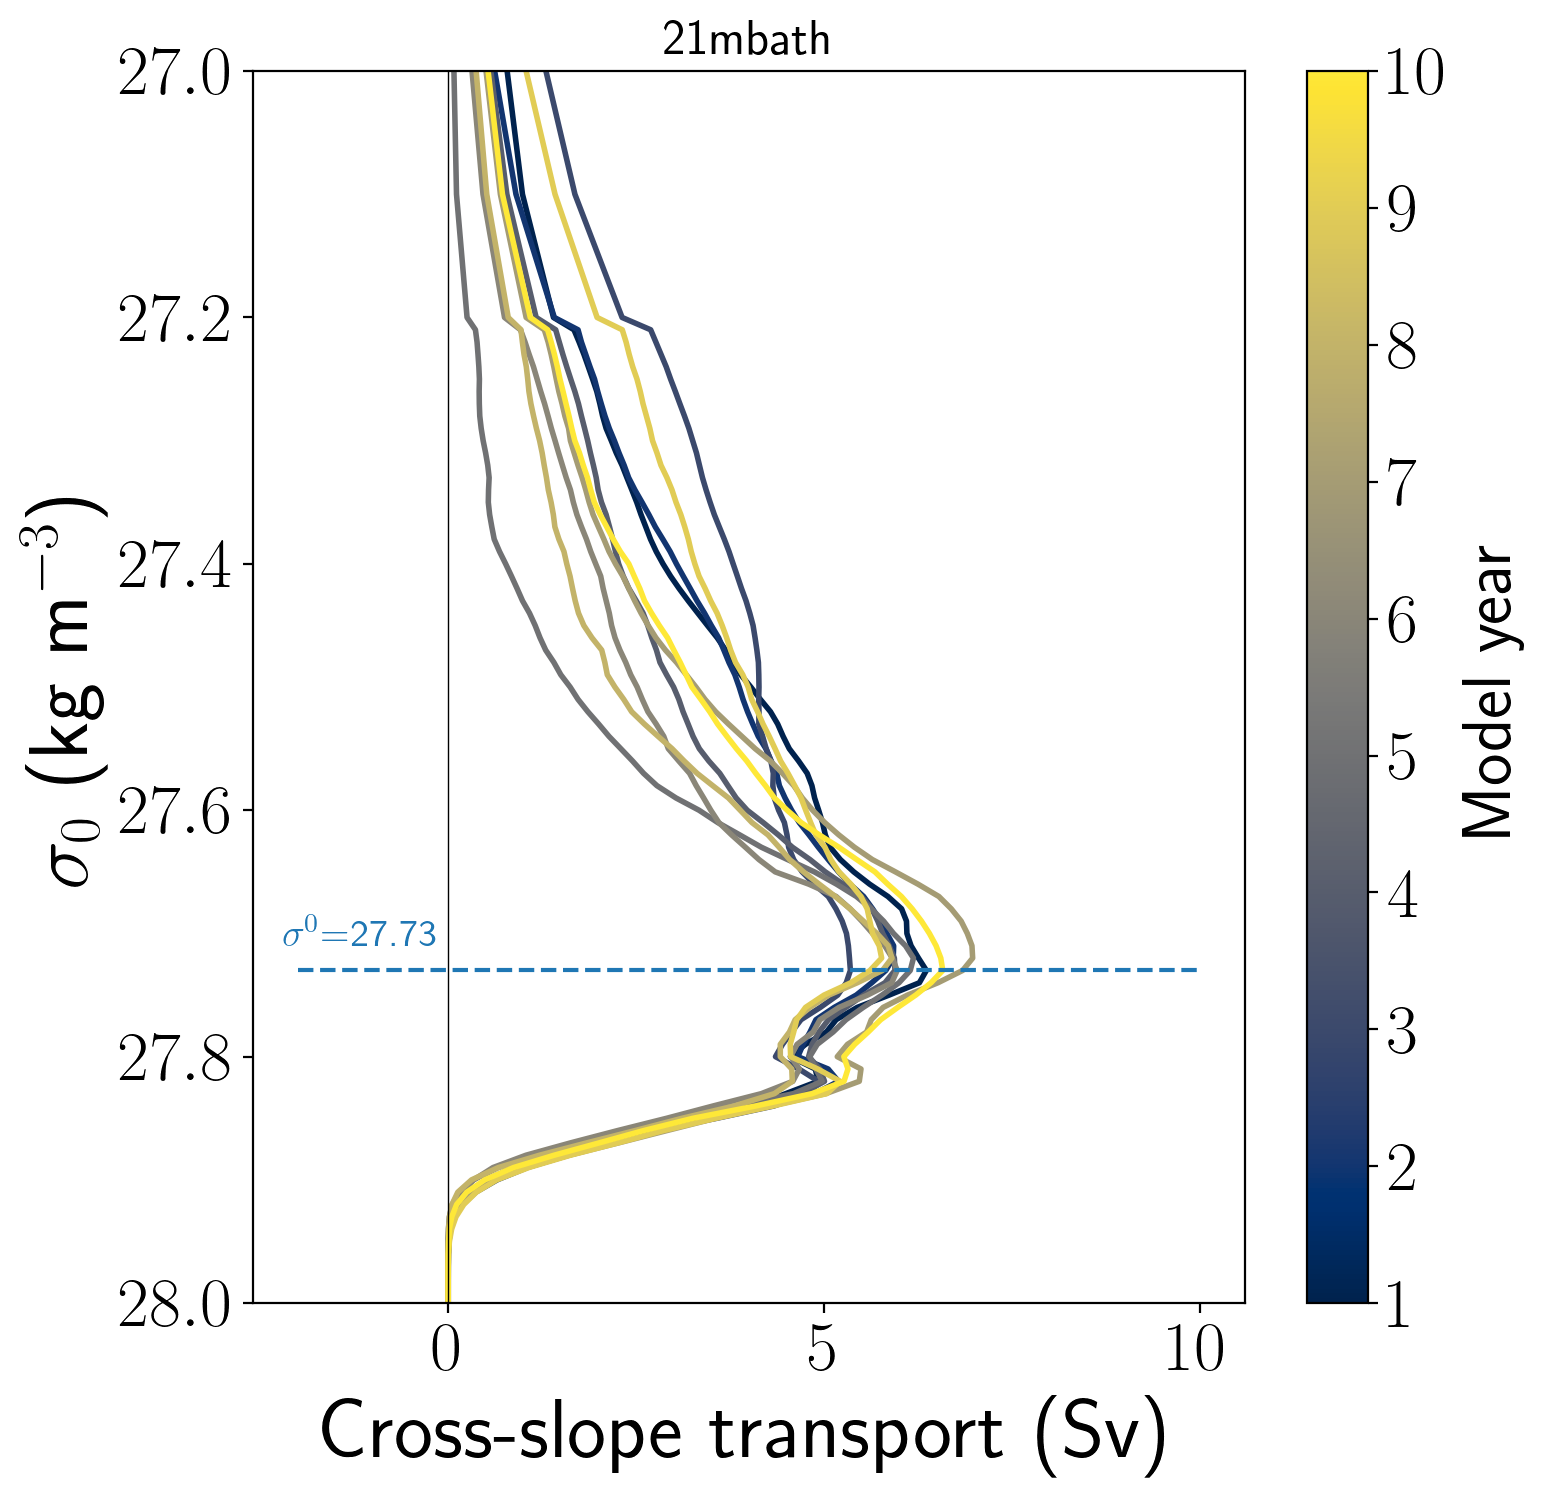

In [127]:
figure = plt.figure(num=1, figsize = (8,8))

yint = np.arange(1, expt0_yran+2, 1)

lc=multiline(expt0_trans_prof/1e6,exp0_revbins, yint, cmap='cividis', lw=2)


plt.ylim((28,27))
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Cross-slope transport (Sv)', fontsize=30)
axcb = figure.colorbar(lc,label='Model year',ticks=np.arange(0,11,1))

plt.text(-2.2,expt0_max_dens-0.02,r"$\sigma^0$="+str(np.round(expt0_max_dens.values,2)),color='tab:blue',fontsize=14)
plt.plot([-2,10],[expt0_max_dens,expt0_max_dens],'--',color='tab:blue',zorder=3);
plt.plot([0, 0], [29,24], 'k', linewidth=0.5)
plt.title(expt0[-nletters:],fontsize=18)
plt.savefig(figpath+'CSMT_'+expt0[-nletters:]+'_sigma0_1000m.png',dpi=300)

In [128]:
nletters=nameletters(expt1)
expt1_trans_prof=np.array(expt1_voltrans.vol_trans_across_contour_binned.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1)).cumsum(dim='isopycnal_bins').isel(isopycnal_bins=slice(None, None, -1)))
exp1_revbins=np.tile(expt1_voltrans.isopycnal_bins,[(expt1_yran+1),1])
#The index of the mdensity with maximum transport is (for the last model year)
expt1_indmax=np.argmax(expt1_trans_prof[-1])
expt1_max_dens=expt1_voltrans.isopycnal_bins[expt1_indmax]


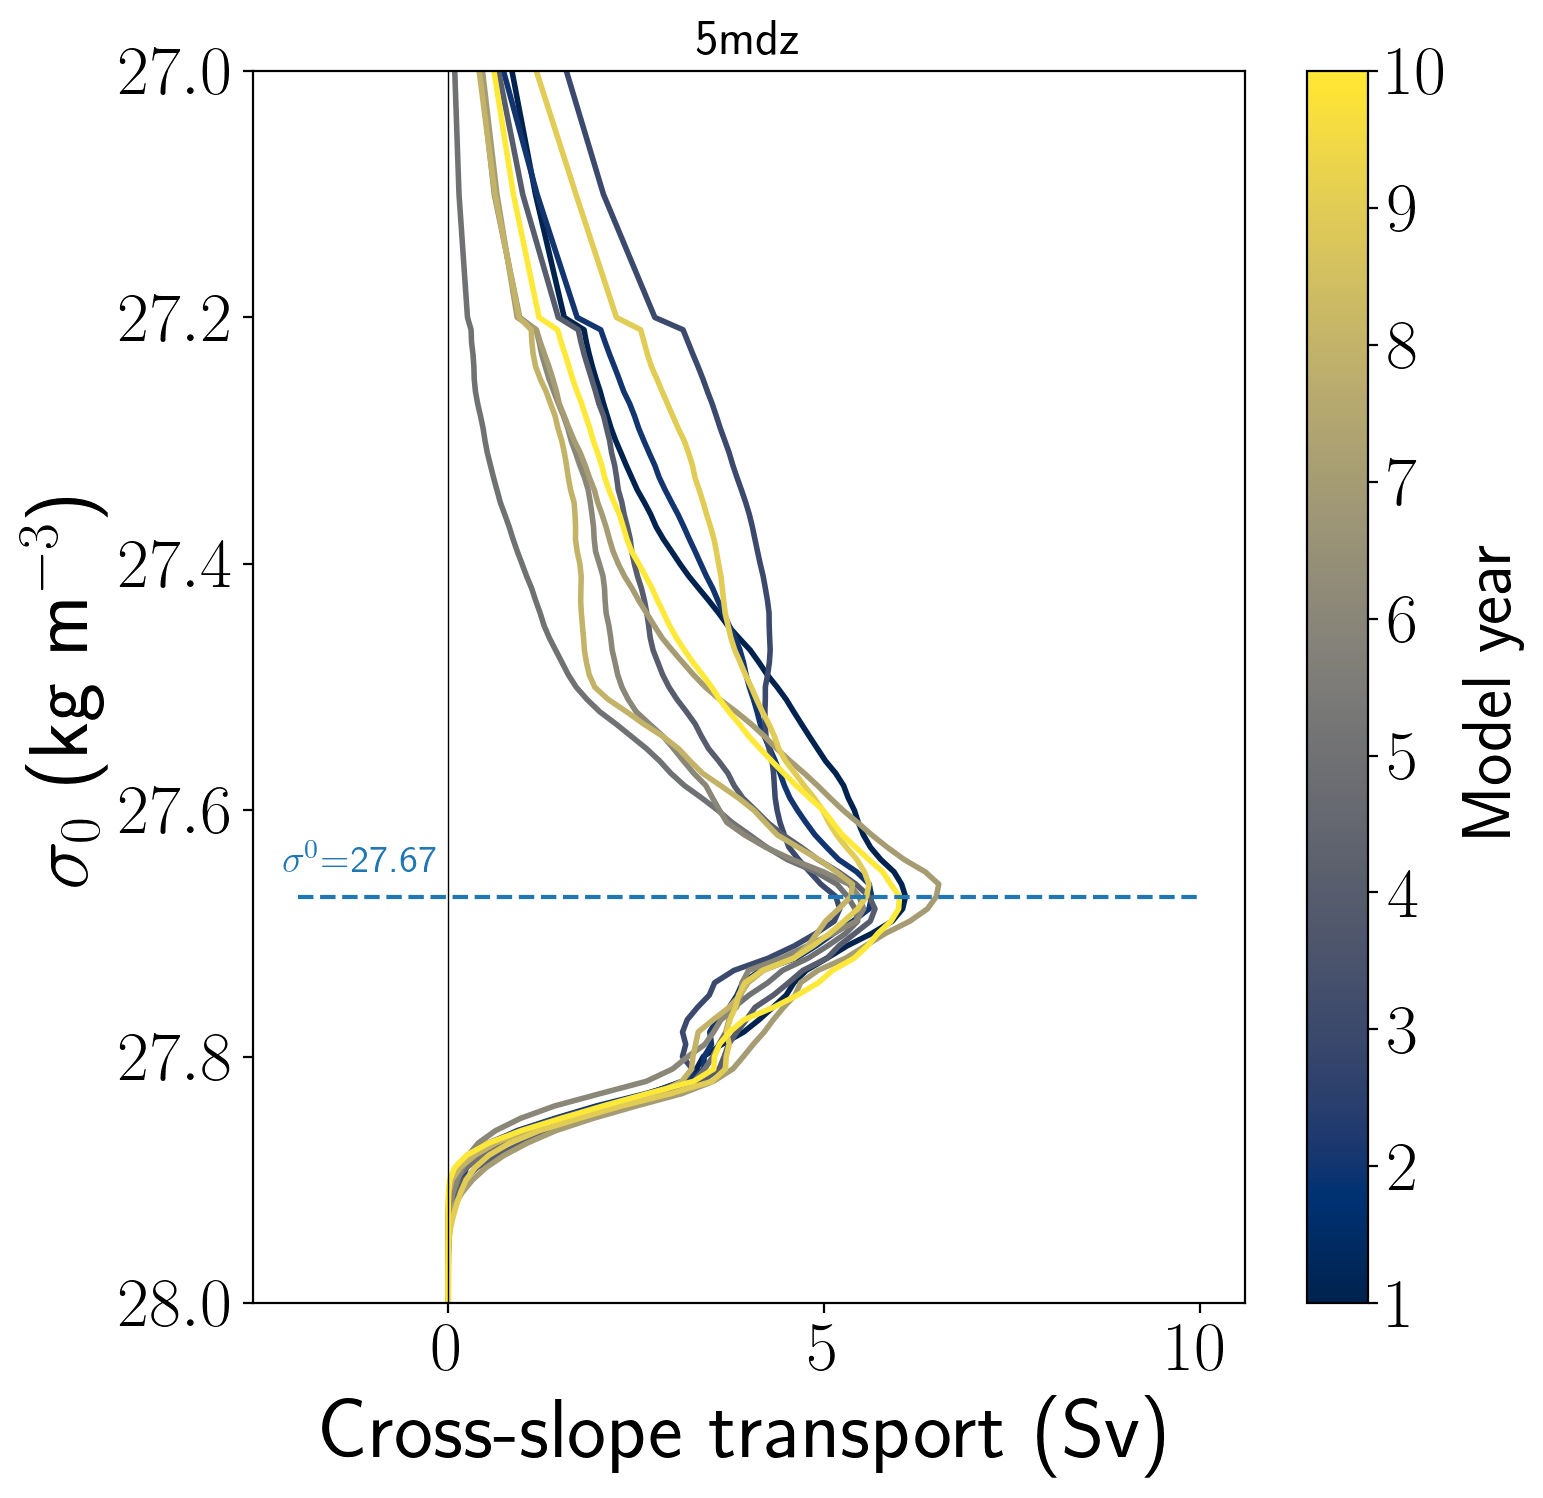

In [129]:
figure = plt.figure(num=1, figsize = (8,8))

yint = np.arange(1, expt1_yran+2, 1)

lc=multiline(expt1_trans_prof/1e6,exp1_revbins, yint, cmap='cividis', lw=2)


plt.ylim((28,27))
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Cross-slope transport (Sv)', fontsize=30)
axcb = figure.colorbar(lc,label='Model year',ticks=np.arange(0,11,1))

plt.text(-2.2,expt1_max_dens-0.02,r"$\sigma^0$="+str(np.round(expt1_max_dens.values,2)),color='tab:blue',fontsize=14)
plt.plot([-2,10],[expt1_max_dens,expt1_max_dens],'--',color='tab:blue',zorder=3);
plt.plot([0, 0], [29,24], 'k', linewidth=0.5)
plt.title(expt1[-nletters:],fontsize=18)
plt.savefig(figpath+'CSMT_'+expt1[-nletters:]+'_sigma0_1000m.png',dpi=300)

In [130]:
nletters=nameletters(expt2)
expt2_trans_prof=np.array(expt2_voltrans.vol_trans_across_contour_binned.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1)).cumsum(dim='isopycnal_bins').isel(isopycnal_bins=slice(None, None, -1)))
exp2_revbins=np.tile(expt2_voltrans.isopycnal_bins,[(expt2_yran+1),1])
#The index of the mdensity with maximum transport is (for the last model year)
expt2_indmax=np.argmax(expt2_trans_prof[-1])
expt2_max_dens=expt2_voltrans.isopycnal_bins[expt2_indmax]

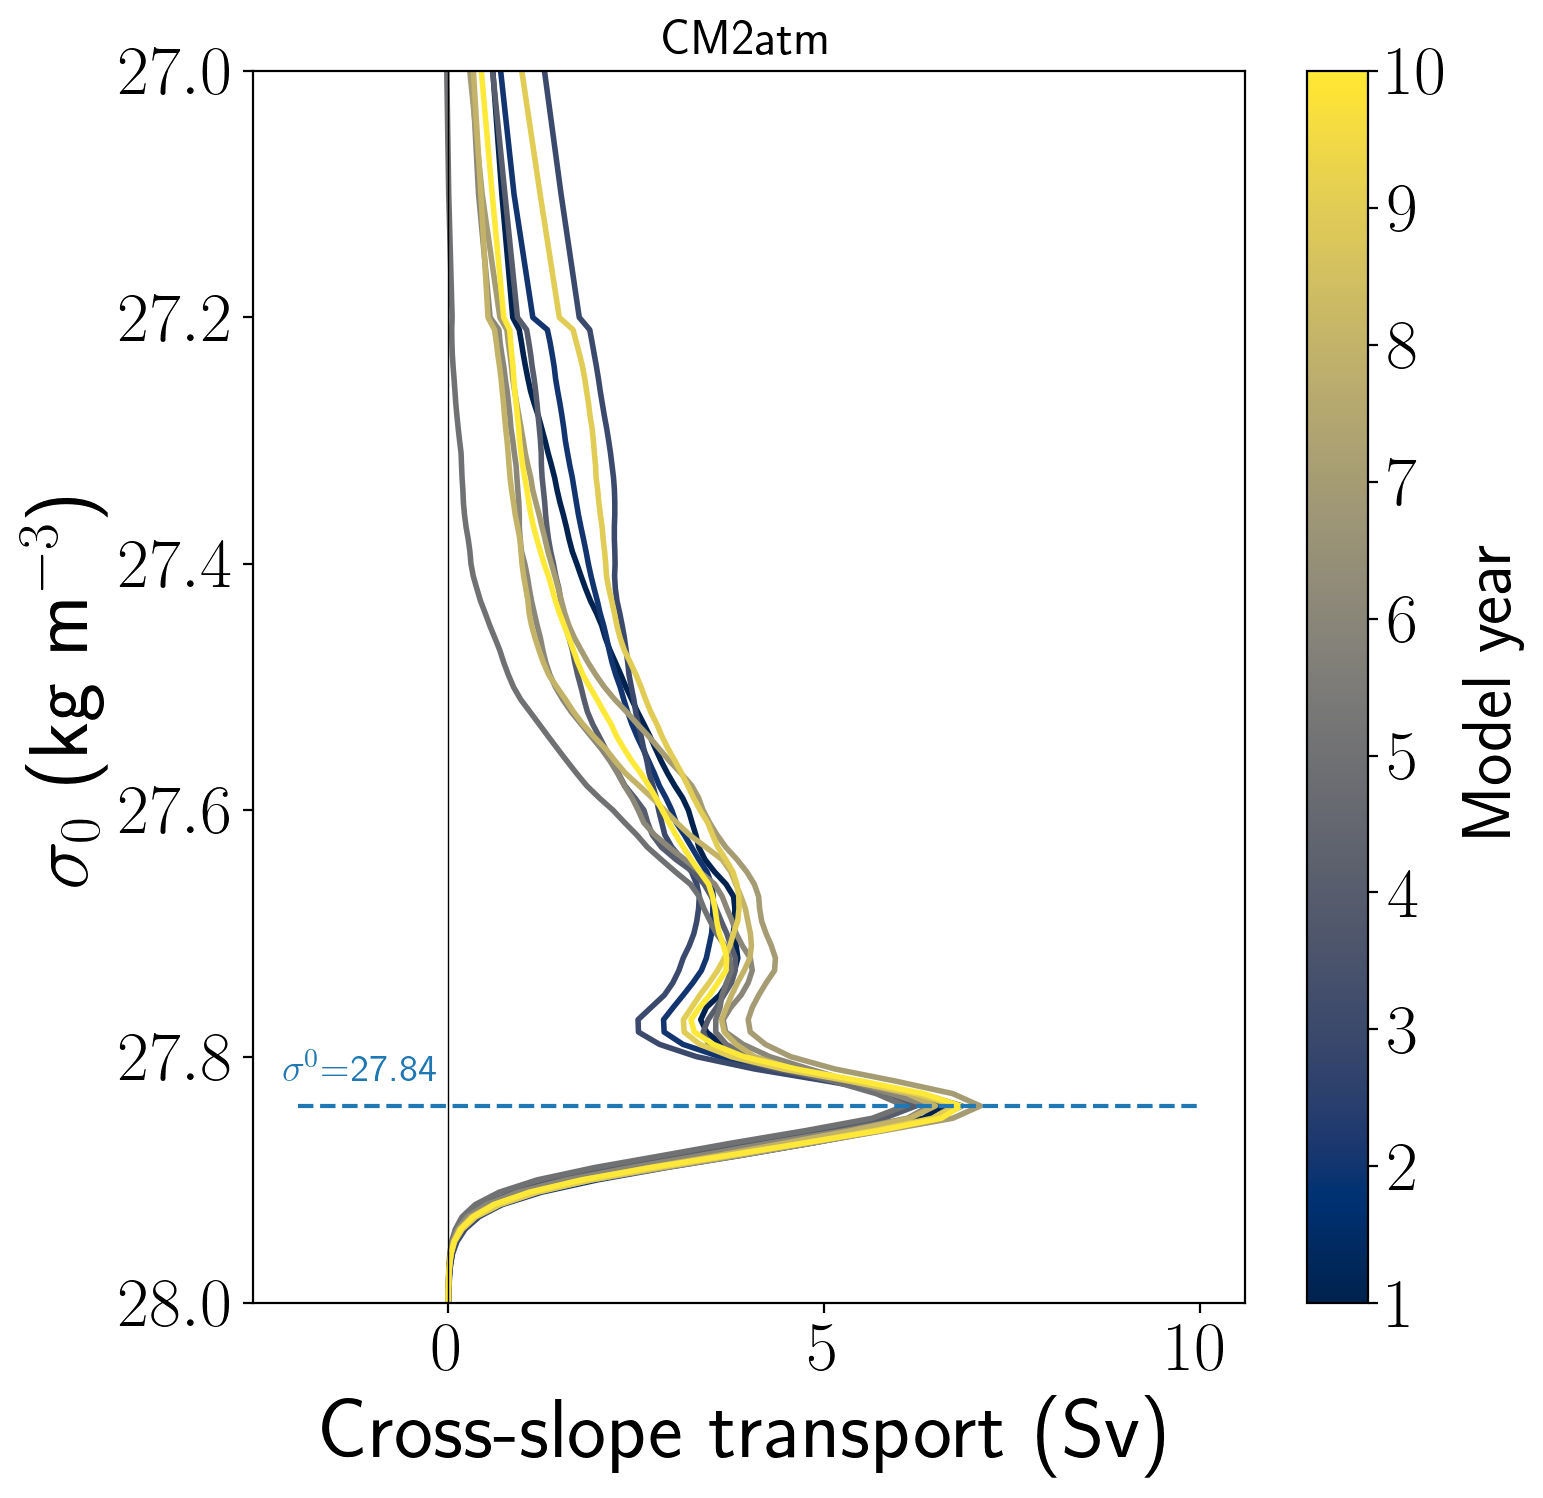

In [131]:
figure = plt.figure(num=1, figsize = (8,8))

yint = np.arange(1, expt2_yran+2, 1)

lc=multiline(expt2_trans_prof/1e6,exp2_revbins, yint, cmap='cividis', lw=2)


plt.ylim((28,27))
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Cross-slope transport (Sv)', fontsize=30)
axcb = figure.colorbar(lc,label='Model year',ticks=np.arange(0,11,1))

plt.text(-2.2,expt2_max_dens-0.02,r"$\sigma^0$="+str(np.round(expt2_max_dens.values,2)),color='tab:blue',fontsize=14)
plt.plot([-2,10],[expt2_max_dens,expt2_max_dens],'--',color='tab:blue',zorder=3);
plt.plot([0, 0], [29,24], 'k', linewidth=0.5)
plt.title(expt2[-nletters:],fontsize=18)
plt.savefig(figpath+'CSMT_'+expt2[-nletters:]+'_sigma0_1000m.png',dpi=300)

In [132]:
nletters=nameletters(expt3)
expt3_trans_prof=np.array(expt3_voltrans.vol_trans_across_contour_binned.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1)).cumsum(dim='isopycnal_bins').isel(isopycnal_bins=slice(None, None, -1)))
exp3_revbins=np.tile(expt3_voltrans.isopycnal_bins,[(expt3_yran+1),1])
#The index of the mdensity with maximum transport is (for the last model year)
expt3_indmax=np.argmax(expt3_trans_prof[-1])
expt3_max_dens=expt3_voltrans.isopycnal_bins[expt3_indmax]

In [ ]:
figure = plt.figure(num=1, figsize = (8,8))

yint = np.arange(1, expt3_yran+2, 1)

lc=multiline(expt3_trans_prof/1e6,exp3_revbins, yint, cmap='cividis', lw=2)


plt.ylim((28,27))
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Cross-slope transport (Sv)', fontsize=30)
axcb = figure.colorbar(lc,label='Model year',ticks=np.arange(0,11,1))

plt.text(-2.2,expt2_max_dens-0.02,r"$\sigma^0$="+str(np.round(expt3_max_dens.values,2)),color='tab:blue',fontsize=14)
plt.plot([-2,10],[expt2_max_dens,expt2_max_dens],'--',color='tab:blue',zorder=3);
plt.plot([0, 0], [29,24], 'k', linewidth=0.5)
plt.title(expt2[-nletters:],fontsize=18)
plt.savefig(figpath+'CSMT_'+expt2[-nletters:]+'_sigma0_1000m.png',dpi=300)